In [1]:
import model.clip as clip
from model.model import ResidualAttentionBlock
import numpy as np
import torch
from torch import nn
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import cv2
from captum.attr import visualization

import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image

from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
os.environ['http_proxy'] = "http://192.41.170.23:3128" 
os.environ['https_proxy'] = "http://192.41.170.23:3128"

In [3]:
# clip.available_models()

In [4]:
model, preprocess = clip.load("ViT-B/16")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

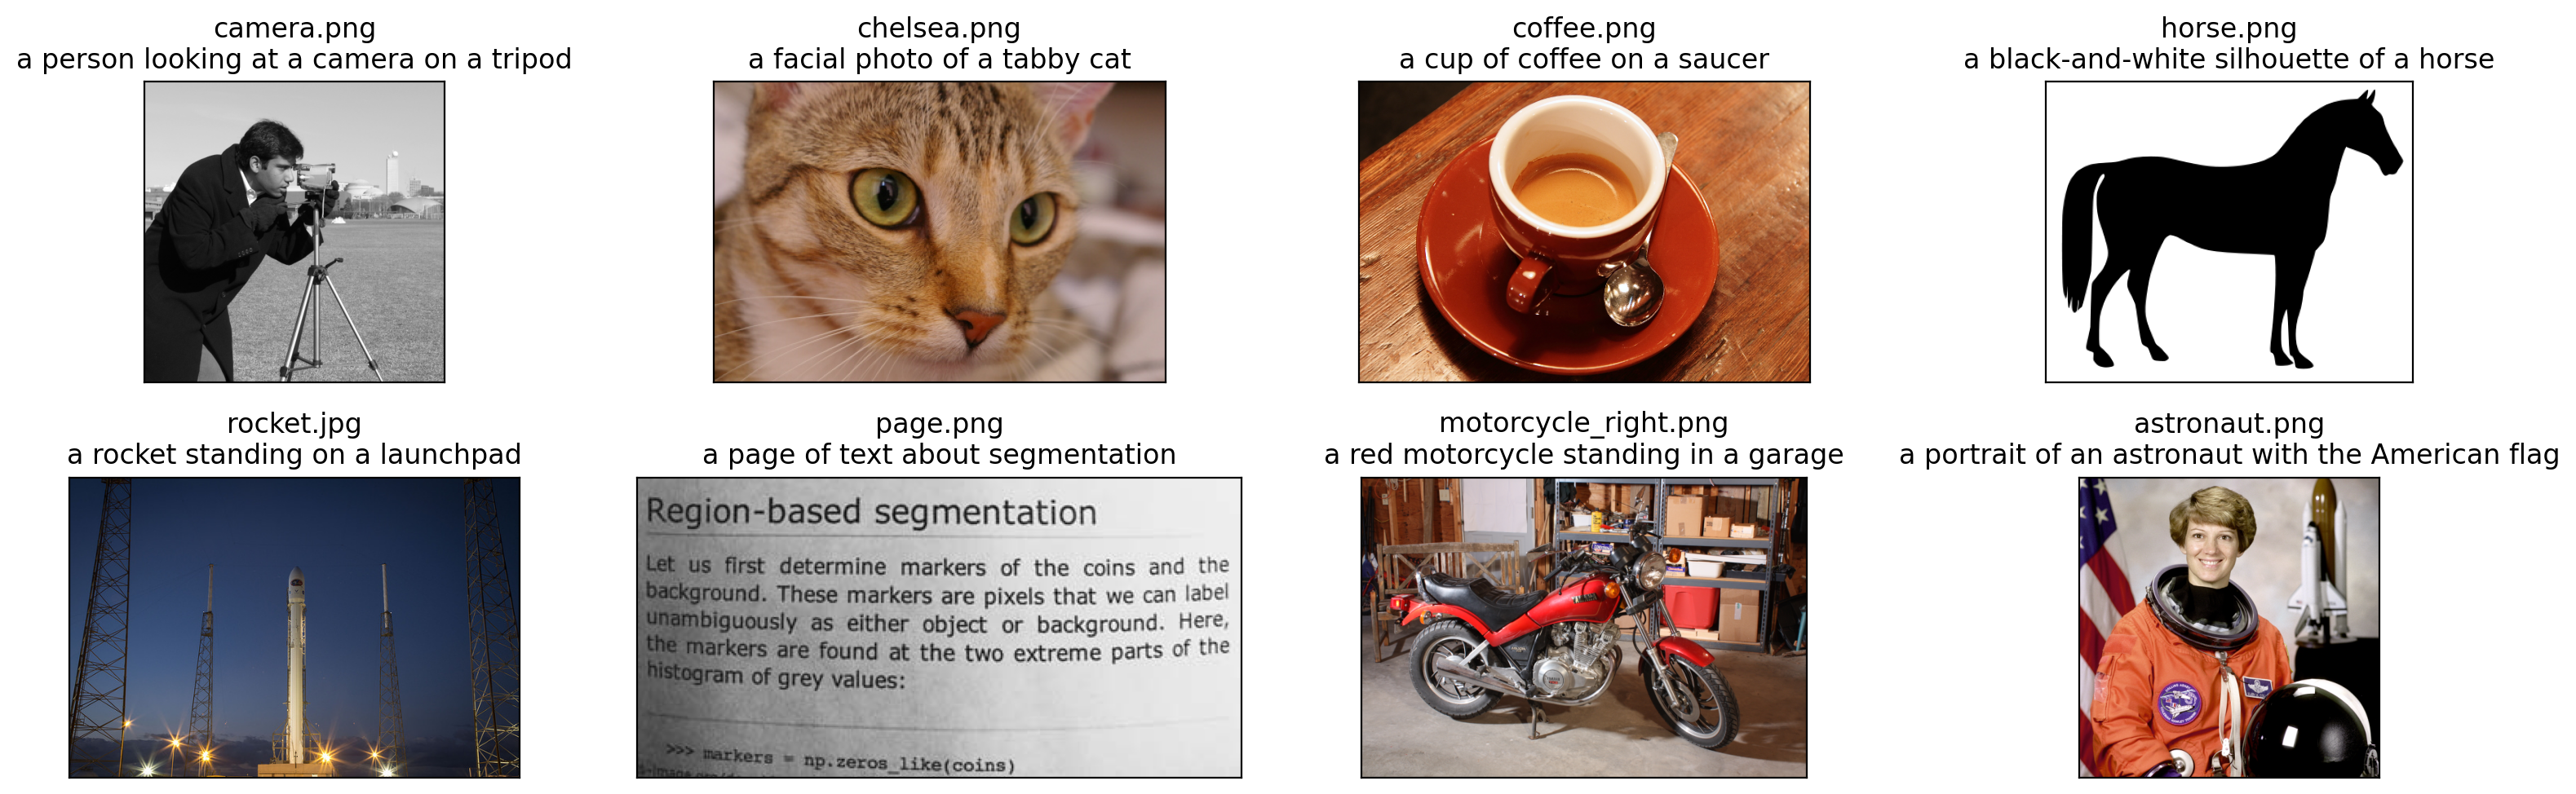

In [6]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
    
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


In [7]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [8]:
def build_similarity_map(similarity_patches, image_size, patch_size):
    num_patch_per_row = image_size / patch_size
    temp_row = []

    for index, patches in enumerate(similarity_patches):
        if index % num_patch_per_row == 0:
            if index != 0:
                temp_row.append(temp_column)
                temp_column = torch.full((patch_size, patch_size), patches)
            else:
                temp_column = torch.full((patch_size, patch_size), patches)
        else:
            temp_filter = torch.full((patch_size, patch_size), patches)
            temp_column = torch.cat((temp_column, temp_filter), -1)
    temp_row.append(temp_column)
    image_filter = torch.cat(temp_row, 0)
    return image_filter

def plot_image_similarity(image, image_filter, text):
    plt.imshow(image.permute(1,2,0), interpolation='nearest')
    plt.title(text)
    plt.imshow(image_filter, alpha=0.4, cmap='jet')
    plt.colorbar()
    
def build_text_image_feature(model, image_input, text_tokens):
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        text_features = model.encode_text(text_tokens).float()
        return image_features, text_features
    
def text_image_similarity(image_features, text_features):
    cos = nn.CosineSimilarity(dim=0)
    similarity_patches = []
    for feature_vector in image_features[1:]:
        similarity = cos(text_features, feature_vector).cpu()
        similarity_patches.append(similarity)
    cls_similarity = cos(image_features[0], text_features).cpu()
    return similarity_patches, cls_similarity

In [20]:
cat_images = [preprocess(Image.open("./image/catdog1.jpg").convert("RGB")), preprocess(Image.open("./image/catdog2.jpg").convert("RGB")), preprocess(Image.open("./image/catdog3.jpg").convert("RGB"))]
cat_image = torch.tensor(np.stack(cat_images)).cuda()

In [23]:
image_no = 0
text_no = 4
patch_size = 16
image_size = 224

text_test = "This an image of a cat"
text_test_token = clip.tokenize([text_test]).cuda()
image_features, text_features = build_text_image_feature(model, cat_image, text_test_token)
text_feature_test = text_features[0]

image_feature_test = image_features[image_no]
image_test = cat_images[image_no]


# image_features, text_features = build_text_image_feature(model, image_input, text_tokens)
# text_test = texts[text_no]
# text_feature_test = text_features[text_no]
# image_feature_test = image_features[image_no]
# image_test = images[image_no]

print("Image Discription:", text_test)

similarity_per_patch, cls_similarity = text_image_similarity(image_feature_test, text_feature_test)
print("Cls image similarity:", cls_similarity)

image_similarity_map = build_similarity_map(similarity_per_patch, image_size,  patch_size)
plot_image_similarity(image_test, image_similarity_map, text_test)

Image Discription: This an image of a cat
Cls image similarity: tensor(0.0772)


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 224 but got size 112 for tensor number 36 in the list.

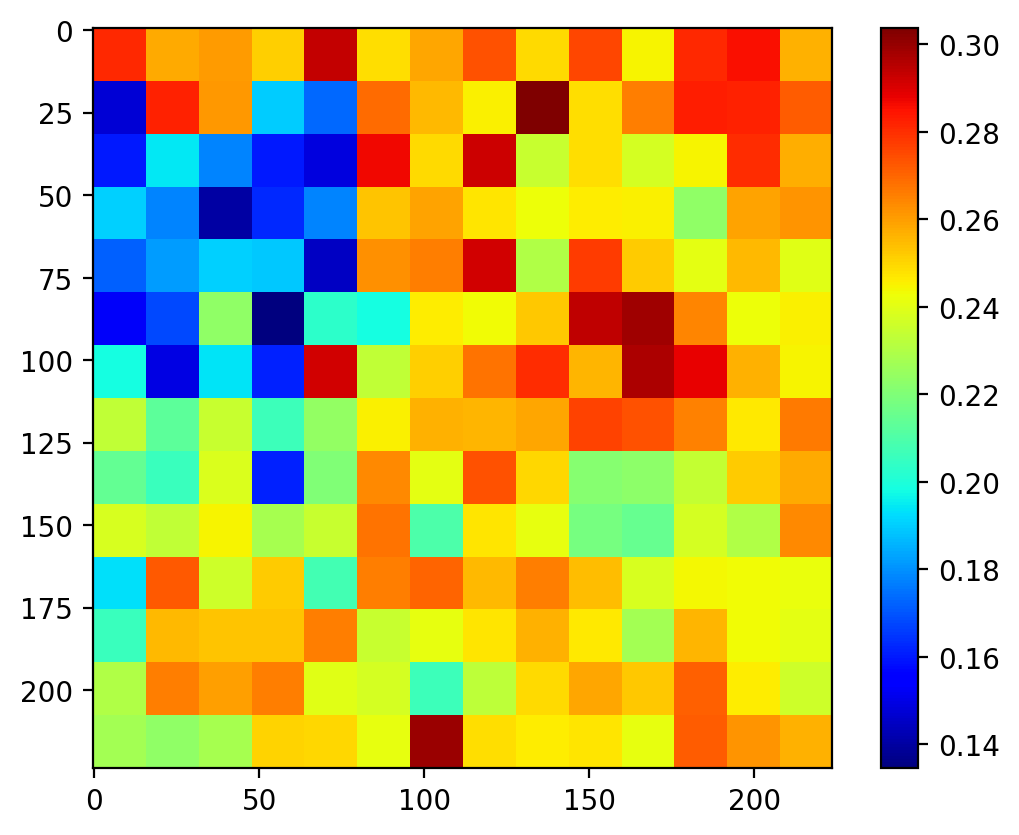

In [11]:
plt.imshow(image_similarity_map, alpha=1, cmap='jet')
plt.colorbar()

In [12]:
model, preprocess = clip.load("ViT-B/16", get_all_token = False)
model.cuda().eval()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Input resolution: 224
Context length: 77
Vocab size: 49408


In [13]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    print(images.shape)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1: 
      # calculate index of last layer 
      start_layer = len(image_attn_blocks) - 1
    
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1: 
      # calculate index of last layer 
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text
   
    return text_relevance, image_relevance

In [14]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [15]:
from model.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [16]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
img_path = "./image/catdog1.jpg"
img = preprocess(Image.open(img_path).convert("RGB")).to(device)
texts = ["a white black dog"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

torch.Size([1, 3, 224, 224])


AttributeError: 'ResidualAttentionBlock' object has no attribute 'attn_probs'